# Sampling and clamping Autoencoders

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

## Applying noise and clamping to input and visualizing their corresponding output 

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0 Train MSE: 0.0422034
19% Train MSE: 0.0420008
2 Train MSE: 0.0404312
3 Train MSE: 0.036007
4 Train MSE: 0.043732
59% Train MSE: 0.039406
6 Train MSE: 0.0409424
7 Train MSE: 0.0404437
8 Train MSE: 0.0388285
9 Train MSE: 0.0381718


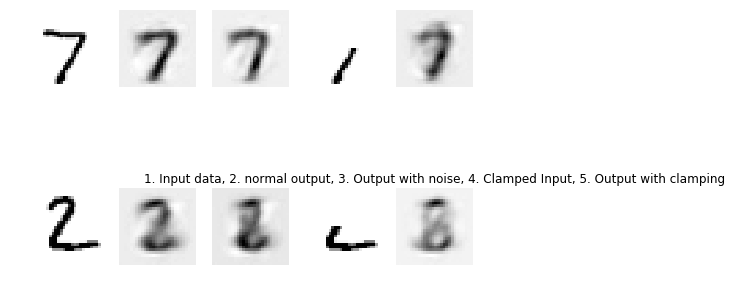

In [55]:

tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()

mnist = input_data.read_data_sets("/tmp/data/")

n_epochs = 10
batch_size = 150
n_test_digits = 2
noise_level = 1.0

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
    X_test = mnist.test.images[:n_test_digits]
    outputs_val = outputs.eval(feed_dict={X: X_test})
    X_noisy = X_test + noise_level * tf.random_normal(tf.shape(X_test))  # adding noise
    outputs_noise_val = outputs.eval(feed_dict={X: X_noisy.eval()})
    X_clamped = X_test.copy()
    np.put(X_clamped[0],[range(392)],np.zeros((2,392)))         # clamping X_test
    np.put(X_clamped[1],[range(392)],np.zeros((2,392)))         # clamping X_test
    outputs_clamped_val = outputs.eval(feed_dict={X: X_clamped})

fig = plt.figure(figsize=(8, 3 * n_test_digits))
for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 5, digit_index * 5 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 5, digit_index * 5 + 2)
    plot_image(outputs_val[digit_index])
    plt.subplot(n_test_digits, 5, digit_index * 5 + 3)
    plot_image(outputs_noise_val[digit_index])
    plt.subplot(n_test_digits, 5, digit_index * 5 + 4)
    plot_image(X_clamped[digit_index])
    plt.subplot(n_test_digits, 5, digit_index * 5 + 5)
    plot_image(outputs_clamped_val[digit_index])

plt.title('1. Input data, 2. normal output, 3. Output with noise, 4. Clamped Input, 5. Output with clamping')
plt.show()    

## denoising autoencoder, using dropout

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0 Train MSE: 0.0359708
1 Train MSE: 0.0323188
2 Train MSE: 0.0318841
3 Train MSE: 0.0294862
4 Train MSE: 0.0296384
5 Train MSE: 0.0286472
6 Train MSE: 0.0297017
7 Train MSE: 0.0258152
8 Train MSE: 0.0279915
9 Train MSE: 0.0294603


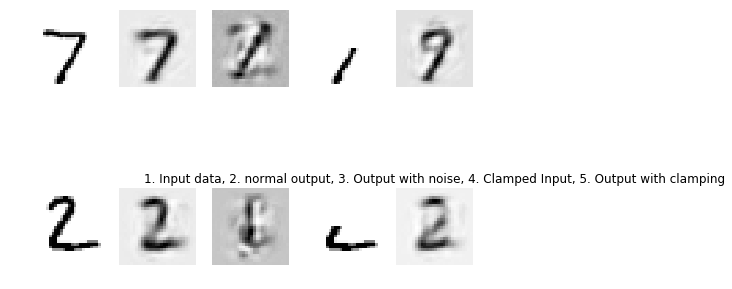

In [56]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()

mnist = input_data.read_data_sets("/tmp/data/")

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

n_epochs = 10
batch_size = 150
n_test_digits = 2

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
    X_test = mnist.test.images[:n_test_digits]
    outputs_val = outputs.eval(feed_dict={X: X_test})
    X_noisy = X_test + noise_level * tf.random_normal(tf.shape(X_test))  # adding noise
    outputs_noise_val = outputs.eval(feed_dict={X: X_noisy.eval()})
    X_clamped = X_test.copy()
    np.put(X_clamped[0],[range(392)],np.zeros((2,392)))         # clamping X_test
    np.put(X_clamped[1],[range(392)],np.zeros((2,392)))         # clamping X_test
    outputs_clamped_val = outputs.eval(feed_dict={X: X_clamped})

fig = plt.figure(figsize=(8, 3 * n_test_digits))
for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 5, digit_index * 5 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 5, digit_index * 5 + 2)
    plot_image(outputs_val[digit_index])
    plt.subplot(n_test_digits, 5, digit_index * 5 + 3)
    plot_image(outputs_noise_val[digit_index])
    plt.subplot(n_test_digits, 5, digit_index * 5 + 4)
    plot_image(X_clamped[digit_index])
    plt.subplot(n_test_digits, 5, digit_index * 5 + 5)
    plot_image(outputs_clamped_val[digit_index])

plt.title('1. Input data, 2. normal output, 3. Output with noise, 4. Clamped Input, 5. Output with clamping')
plt.show()    